<a href="https://colab.research.google.com/github/kibbm/ML-Tensorflow/blob/master/%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_LSTM_%EC%98%81%ED%99%94%EB%A6%AC%EB%B7%B0_1107(%EC%98%A4%ED%9B%84_%EC%99%84%EC%84%B1!).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*신경망 교과서 /* 
## 6장 **LSTM을 사용한 영화 리뷰 감성 분석**

https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/blob/master/Chapter06/lstm.py

6.6 IMDB영화 리뷰 데이터 셋

In [1]:
import matplotlib
#matplotlib.use("TkAgg")

from keras.datasets import imdb
training_set, testing_set = imdb.load_data(index_from = 3)
X_train, y_train = training_set
X_test, y_test = testing_set

print(X_train[0])

17465344/17464789 [==============================] - 2s 0us/step
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32

In [18]:
#추가
import matplotlib
matplotlib.use('TkAgg')


단어가 아닌 숫자가 나온 이유는 단어를 숫자로 이미 인코딩했기 때문이다. 
케라스에 내장된 딕셔너리를 사용해 단어로 다시 변환할 수 있다.

In [2]:
word_to_id = imdb.get_word_index()
word_to_id = {key:(value+3) for key, value in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
id_to_word = {value:key for key, value in word_to_id.items()}

1646592/1641221 [==============================] - 0s 0us/step


이제 실제 리뷰를 출력할 수 있다.

In [3]:
print(' '.join(id_to_word[id] for id in X_train[159]))

<START> a rating of 1 does not begin to express how dull depressing and relentlessly bad this movie is


159번.. 분명 이 리뷰의 감성은 부정적이다. y값을 출력해 확인하자.

In [4]:
print(y_train[159])

0


값이 0이면 부정, 1이면 긍정리뷰임. 
긍정리뷰도 출력해보자.


In [5]:
print(' '.join(id_to_word[id] for id in X_train[6]))

<START> lavish production values and solid performances in this straightforward adaption of jane austen's satirical classic about the marriage game within and between the classes in provincial 18th century england northam and paltrow are a salutory mixture as friends who must pass through jealousies and lies to discover that they love each other good humor is a sustaining virtue which goes a long way towards explaining the accessability of the aged source material which has been toned down a bit in its harsh scepticism i liked the look of the film and how shots were set up and i thought it didn't rely too much on successions of head shots like most other films of the 80s and 90s do very good results


In [6]:
print(y_train[6])

1


6.7 단어의 벡터 표현

 cf) CNN: 입력데이터인 이미지는 기본적으로 3차원 벡터(즉, 행렬) 형태이며, 각 차원은 이미지의 가로, 세로, 채널수를 의미한다. 벡터 값은 각 화소의 강도를 나타낸다.

* 6.7.1 원핫 인코딩
: **단어**는 이미지와 다르게 **숫자로 변환해야** 한다. 
* 6.7.2 단어 임베딩
: 단어를 더 나은 형태의 벡터로 표현하는 방법을 학습하는 기법. 단어 임베딩으로 만든 벡터가 원핫 인코딩보다 더 나은 이유는 **벡터 차원이 더 작고 유사한 단어들이 서로 가깝게 놓이기 때문**. 


6.8 모델 아키텍처

     입력  --->    단어   -->    LSTM 레이어    --> 밀집 레이어     --> 출력
   (영화 리뷰)  임베딩 레이어              시그모이드 함수 사용    (리뷰의 감성)

   6.6절에서 살펴봤듯이 케라스에 내장된 IMDB 영화 리뷰 데이터셋에는 영단어가 이미 숫자로 인코딩 됐다. 하지만 아직 한가지 문제가 남아있다. 영화리뷰, 즉 영어 문장은 길이가 제각각 다르다. 각 리뷰를 단순히 벡터로 만들면 벤터 길이 또한 각각 다르며, 신경망은 길이가 다른 벡터를 입력받을 수 없다.(해결방법은 6.9절에서)

*   6.8.1 입력
*   6.8.2 단어 임베딩 레이어
*   6.8.3 LSTM레이어
*   6.8.4 밀집 레이어
*   6.8.5 출력

6.9 모델 구성


*   6.9.1 데이터 입수
*   6.9.2 제로 패딩: 영화 리뷰의 길이를 maxlen매개변수로 정의해 이 문제를 해결해보자. maxlen보다 긴 리뷰는 자르고 maxlen보다 짧은 리뷰에는 0을 채울 수 있다. 이 과정을 제로 패딩(zero padding)이라고 하며, 모든 입력 벡터를 동일한 길이로 맞춰준다. 
*   6.9.3 단어 임베딩 레이어와 LSTM 레이어: 전처리한 다음에는 모델을 만들어야 한다. 
*   6.9.4 모델 컴파일 및 훈련: 컴파일하려면 매개변수(손실함수, 옵티마이저)를 지정해야 한다. 
       - 손실함수) 목표변수가 이진변수라면, binary_crossentropy | 다중 클래스를 출력한다면, categoricla_crossentropy
       - 옵티마이저) 데이터셋에 따라 옵티마이저 성능이 달라지며, 경사 소실 문제와 경사 폭증 문제 때문에 특정 옵티마이저가 데이터셋을 제대로 학습하지 못하는 경우도 있음. 예>sgd, RMSprop, adam



In [7]:
# 6.9.1 데이터 입수
from keras.datasets import imdb

training_set, testing_set = imdb.load_data(num_words = 10000)
X_train, y_train = training_set
X_test, y_test = testing_set

print("Number of training samples = {}".format(X_train.shape[0]))
print("Number of testing samples = {}".format(X_test.shape[0]))

Number of training samples = 25000
Number of testing samples = 25000


훈련 데이터셋과 테스트 데이터셋에 각각 25,000 개의 로우가 있다. 

In [8]:
# 6.9.2 제로 패딩
'''
제로피딩은 케랄스의 preprocessing모둘에 있는 sequence클래스를 사용해 손쉽게 적용할 수 있다. 
- sequence클래스는 이 밖에도 시퀀스 데이터를 다루는 여러 유용한 기능을 제공한다.
- maxlen을 100으로 지정하고 훈련 데이터셋과 테스트 데이터셋을 함수에 전달한다. 
훈련데이터셋과 테스트 데이터셋은 각각 25,000개의 로우가 있다. 
'''
from keras.preprocessing import sequence

X_train_padded = sequence.pad_sequences(X_train, maxlen = 100) #시퀀스 데이터에 제로패딩 적용
X_test_padded = sequence.pad_sequences(X_test, maxlen = 100)

print("X_train vector shape = {}".format(X_train_padded.shape)) #벡터길이 출력해 제로 패딩 결과 보기.
print("X_test vector shape = {}".format(X_test_padded.shape))

X_train vector shape = (25000, 100)
X_test vector shape = (25000, 100)


In [9]:
#   6.9.3 단어 임베딩 레이어와 LSTM 레이어
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense

model = Sequential()

model.add(Embedding(input_dim = 10000, output_dim=128)) #입력벡터 차원을 지정(입력 벡터의 차원 수는 데이터셋이 있는 
                              #단어의 고유 개수와 동일해야 함.따라서, 앞서 데이터 셋을 가져올 때 지정했던 num_words매개 변수 값을 그대로 사용한다.)
                              #출력 벡터 차원을 128로 지정한다. 
model.add(LSTM(units=128)) #레이어의 반복 유닛 수를 지정. LSTM레이어를 생성해 모델에 추가. 
model.add(Dense(units=1, activation='sigmoid')) #dense레이어를 추가하고 sigmoid를 활성화 함수로 지정한다. dense레이어의 역할은 모델 출력을 0과 1사이의 확률로 변환하는 것이다. 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [10]:
# 6.9.4 모델 컴파일 및 훈련

#1> SGD옵티마이저
Optimizer = 'SGD'
model.compile(loss='binary_crossentropy', optimizer = Optimizer)

#에폭 10, 테스트셋을 validation_data로 지정해 모델 훈련 
scores = model.fit(x=X_train_padded, y=y_train, 
                  batch_size = 128, epochs=10, 
                  validation_data=(X_test_padded, y_test))
#반환한 scores객체는 훈련 정확도, 검증 정확도, 에폭별 손실 값 등을 담은 파이썬 딕셔너리다. 

Epoch 1/10
196/196 [==============================] - 91s 465ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/10
196/196 [==============================] - 92s 472ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/10
196/196 [==============================] - 92s 468ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/10
196/196 [==============================] - 91s 463ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/10
196/196 [==============================] - 91s 466ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/10
196/196 [==============================] - 92s 470ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/10
196/196 [==============================] - 91s 465ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 8/10
196/196 [==============================] - 91s 464ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 9/10
196/196 [==============================] - 92s 469ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 10/10
196/196 [==============================] - 91s 463ms/step - l

In [11]:
# 옵티마이저 별로 함수 만들기....optimizer를 인수로 받는 train_model()함수를 정의할 수 있다. 

def train_model(Optimizer, X_train, y_train, X_val, y_val):
  model = Sequential()
  model.add(Embedding(input_dim = 10000, output_dim=128))
  model.add(LSTM(units=128))
  model.add(Dense(units=1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer = Optimizer, metrics=['accuracy'])
  scores = model.fit(X_train, y_train, batch_size=128, 
                     epochs=10, 
                     validation_data=(X_val, y_val),
                     verbose=0)
  return scores, model


In [19]:
# 이 함수에 sgd, RMSprop, adam 옵티마이저를 각각 전달해 세가지 모델을 만든다.

sgd_score, SGD_model = train_model(Optimizer = 'sgd', 
                                   X_train = X_train_padded,
                                   y_train = y_train,
                                   X_val = X_test_padded,
                                   y_val = y_test)

RMSprop_score, RMSprop_model = train_model(Optimizer = 'RMSprop', 
                                   X_train = X_train_padded,
                                   y_train = y_train,
                                   X_val = X_test_padded,
                                   y_val = y_test)

Adam_score, Adam_model = train_model(Optimizer = 'adam', 
                                   X_train = X_train_padded,
                                   y_train = y_train,
                                   X_val = X_test_padded,
                                   y_val = y_test)                                   

In [20]:
#test
sgd_score.history['accuracy']

[0.4917599856853485,
 0.4939599931240082,
 0.49751999974250793,
 0.5045599937438965,
 0.5091599822044373,
 0.5104399919509888,
 0.5174400210380554,
 0.5158399939537048,
 0.5252799987792969,
 0.5271199941635132]

6.10 결과 분석

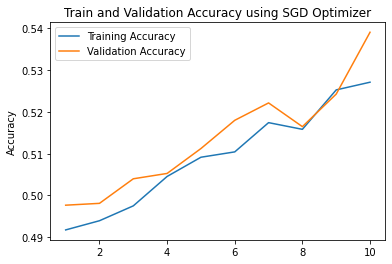

In [26]:
from matplotlib import pyplot as plt

plt.plot(range(1, 11), sgd_score.history['accuracy'], label='Training Accuracy')              # 오류................KeyError: 'acc'
plt.plot(range(1, 11), sgd_score.history['val_accuracy'], label='Validation Accuracy')
#plt.axis([1, 10, 0, 1, 0])
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using SGD Optimizer')
plt.legend()
plt.show()

#훈련 정확도와 검증 정확도가 50%에서 멈췄다.ㅠㅠ

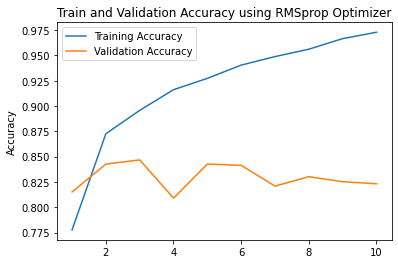

In [30]:
plt.plot(range(1,11), RMSprop_score.history['accuracy'], label='Training Accuracy')  
plt.plot(range(1,11), RMSprop_score.history['val_accuracy'], label='Validation Accuracy')
#plt.axis([1, 10, 0, 1, 0])
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using RMSprop Optimizer')
plt.legend()
plt.show()

#RMSprop의 결과가 훨씬 낫다..에폭 10회만으로도 95%이상의 훈련 정확도와 85%의 검증 정확도를 얻었다. 

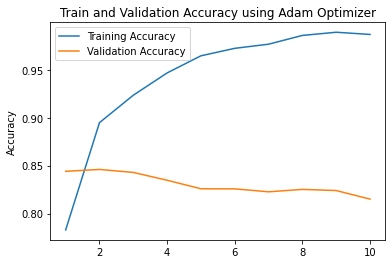

In [31]:
plt.plot(range(1, 11), Adam_score.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, 11), Adam_score.history['val_accuracy'], label='Validation Accuracy')
#plt.axis([1, 10, 0, 1, 0])
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy using Adam Optimizer')
plt.legend()
plt.show()

# adam옵티마이저 결과도 나쁘지 않다. 에폭 10회에서 훈련 정확도가 거의 100%에 가깝다. 
#  반면 검증 정확도는 약 80%로 나왔다. 이는 adam 옵티마이저가 과적합을 유발할 가능성이 있다는 뜻이다. 

반면 RMSprop옵티마이저는 훈련 정확도와 검증  정확도 간 차이가 더 작다. 따라서 예제 데이터셋에는 RMSprop옵티마이저를 사용한 LSTM신경망이 가장 적합하다고 결론 내릴 수 있다. 이제 RMSprop을 사용한 모델로 정확도를 더 분석해보자~~ => **혼돈행렬**



*   진음성: 실제 클래스가 음성(부정적 리뷰)이고 모델도 음성으로 예측한 경우
*   위양성: 실제 클래스가 음성(부정적 리뷰)이고 모델도 양성으로 예측한 경우
*   위음성: 실제 클래스가 양성(긍정적 리뷰)이고 모델도 음성으로 예측한 경우
*   진양성: 실제 클래스가 양성(긍정적 리뷰)이고 모델도 양성으로 예측한 경우




Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


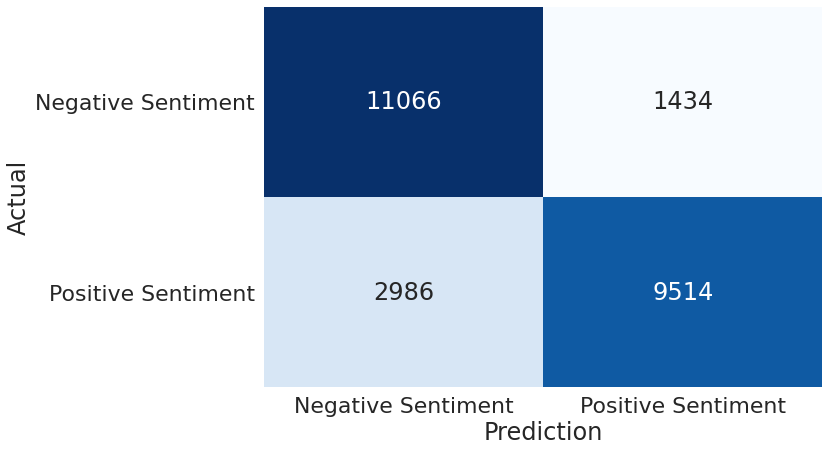

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.set(font_scale=2)
y_test_pred = RMSprop_model.predict_classes(X_test_padded)
c_matrix = confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(c_matrix, annot=True, xticklabels=['Negative Sentiment', 'Positive Sentiment'],
                                      yticklabels=['Negative Sentiment', 'Positive Sentiment'],
                 cbar=False, cmap='Blues', fmt='g')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.show()

모델이 테스트 데이터셋을 대부분 정확하게 분류했다. 진음성과 진양성이 전체의 85%정도를 차지했다. 즉, 영화 리뷰의 감성을 85% 정확도로 분류할 수 있다는 뜻이다. 

모델이 잘못 분류한 결과를 일부 골라 살펴보자. 

In [33]:
# 모델이 잘못 분류한 결과를 일부 골라 살펴보자. 
false_negatives = []
false_positivies = []

for i in range(len(y_test_pred)):
  if y_test_pred[i][0] != y_test[i]:
    if y+test[i] == 0: #위양성
      false_positives.append(i)
    else:
      false_negatives.append(i)

      

NameError: ignored